# Imports

In [2]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_predict, LeaveOneOut
import os
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Dados

In [3]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'Partial Components Analysis'

file_path_raw_cal = base_path / 'RAW_calibration.xlsx'
file_path_msc_cal = base_path / 'MSC_calibration.xlsx'
file_path_snv_cal = base_path / 'SNV_calibration.xlsx'
file_path_sg_cal = base_path / 'SG_calibration.xlsx'

df_raw_cal = pd.read_excel(file_path_raw_cal)
df_msc_cal = pd.read_excel(file_path_msc_cal)
df_snv_cal = pd.read_excel(file_path_snv_cal)
df_sg_cal = pd.read_excel(file_path_sg_cal)

file_path_raw_val = base_path / 'RAW_validation.xlsx'
file_path_msc_val = base_path / 'MSC_validation.xlsx'
file_path_snv_val = base_path / 'SNV_validation.xlsx'
file_path_sg_val = base_path / 'SG_validation.xlsx'

df_raw_val = pd.read_excel(file_path_raw_val)
df_msc_val = pd.read_excel(file_path_msc_val)
df_snv_val = pd.read_excel(file_path_snv_val)
df_sg_val = pd.read_excel(file_path_sg_val)

# Testes

In [4]:
X_test, y_test = df_msc_val.iloc[:,6:], df_msc_val['SST'].values
X_train, y_train = df_msc_cal.iloc[:,6:], df_msc_cal['SST'].values

In [5]:
X_train.shape, X_test.shape

((175, 2151), (75, 2151))

In [8]:
# Função para calcular as métricas
def calculate_metrics(y_true, y_pred):
    correlation_coefficient = np.corrcoef(y_true, y_pred)[0, 1]
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mean_y_true = np.mean(y_true)
    relative_absolute_error = 100 * (mae / np.mean(np.abs(y_true - mean_y_true)))
    root_relative_squared_error = 100 * (rmse / np.std(y_true))

    return {
        "Correlation coefficient": correlation_coefficient,
        "Mean absolute error": mae,
        "Root mean squared error": rmse,
        "Relative absolute error": relative_absolute_error,
        "Root relative squared error": root_relative_squared_error,
        "Total Number of Instances": len(y_true)
    }

def display_metrics(title, metrics):
    print(f"\n=== {title} ===")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

# Configurações do modelo SVR com kernel RBF
model = SVR(
    C=1,                    # Regularização
    epsilon=1.0E-12,        # Tolerância
    kernel='poly',          # Kernel Polinomial
    degree=1,               # Grau do polinômio
    coef0=1,                # Termo de bias
    tol=0.001,              # Tolerância para precisão
    cache_size=250007,      # Tamanho do cache
    shrinking=True,         # Usar a heurística de shrinking
    verbose=False            # Exibir mensagens detalhadas
)
# Treinar o modelo
model.fit(X_train, y_train)

# Fazer previsões no conjunto de treinamento
y_train_pred = model.predict(X_train)
training_metrics = calculate_metrics(y_train, y_train_pred)
display_metrics("Training Metrics", training_metrics)

# Validação cruzada Leave-One-Out (LOO)
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
y_train_cv = cross_val_predict(model, X_train, y_train, cv=loo)
cv_metrics = calculate_metrics(y_train, y_train_cv)
display_metrics("Cross-Validation Metrics", cv_metrics)

# Avaliação final no conjunto de teste
y_pred_val = model.predict(X_test)
validation_metrics = calculate_metrics(y_test, y_pred_val)
display_metrics("Validation Metrics", validation_metrics)


=== Training Metrics ===
Correlation coefficient: 0.6075
Mean absolute error: 1.9977
Root mean squared error: 2.4122
Relative absolute error: 90.4784
Root relative squared error: 90.8090
Total Number of Instances: 175.0000

=== Cross-Validation Metrics ===
Correlation coefficient: 0.5444
Mean absolute error: 2.0478
Root mean squared error: 2.4530
Relative absolute error: 92.7471
Root relative squared error: 92.3443
Total Number of Instances: 175.0000

=== Validation Metrics ===
Correlation coefficient: 0.5055
Mean absolute error: 1.5399
Root mean squared error: 1.9278
Relative absolute error: 89.3475
Root relative squared error: 91.6123
Total Number of Instances: 75.0000


In [11]:
# Definir o pipeline
pipeline = make_pipeline(StandardScaler(), SVR(kernel='rbf'))

# Definir os parâmetros para o GridSearch
param_grid = {
    'svr__C': [0.1, 1,4],  # Valores de regularização
    'svr__gamma': ['auto', 0.1, 0.01, 0.001],  # Parâmetro gamma
    'svr__epsilon': [0.001, 1.0E-8,1.0E-12],  # Epsilon para a função de perda
    'svr__tol': [1e-3, 1e-4, 1e-5],  # Tolerância para critério de parada
    'svr__max_iter': [1000, 10000, -1],  # Número máximo de iterações (-1 para ilimitado)
}


# Definir o GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',  # Usando MAE como métrica de avaliação
    cv=175,  # Validação cruzada com 5 folds
    n_jobs=-1,  # Utiliza todos os processadores disponíveis
    verbose=3  # Mostra detalhes do processo
)

# Treinar o GridSearchCV
grid_search.fit(X_train, y_train)

# Resultados do GridSearch
print("Melhores parâmetros encontrados:")
print(grid_search.best_params_)

# Fazer previsões no conjunto de teste usando o melhor modelo encontrado
y_pred = grid_search.predict(X_test)

# Calcular e exibir as métricas de desempenho
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nResultados no conjunto de teste:")
print(f"MAE (Mean Absolute Error): {mae:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")
print(f"R² (Coeficiente de Determinação): {r2:.4f}")


Fitting 175 folds for each of 324 candidates, totalling 56700 fits
Melhores parâmetros encontrados:
{'svr__C': 4, 'svr__epsilon': 0.001, 'svr__gamma': 'auto', 'svr__max_iter': 1000, 'svr__tol': 0.0001}

Resultados no conjunto de teste:
MAE (Mean Absolute Error): 0.9246
RMSE (Root Mean Squared Error): 1.1486
R² (Coeficiente de Determinação): 0.7021


# Algoritmo

In [28]:
def SVM(X_cal, y_cal, X_val, y_val, filter, attribute):
    # Função para calcular as métricas
    def calculate_metrics(y_true, y_pred):
        # Calcular as métricas adicionais
        model = LinearRegression().fit(y_pred.reshape(-1, 1), y_true)
        slope = model.coef_[0]
        offset = model.intercept_
        r2 = r2_score(y_true, y_pred)

        # Calcular as métricas já existentes
        correlation_coefficient = np.corrcoef(y_true, y_pred)[0, 1]
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mean_y_true = np.mean(y_true)
        relative_absolute_error = 100 * (mae / np.mean(np.abs(y_true - mean_y_true)))
        root_relative_squared_error = 100 * (rmse / np.std(y_true))

        return {
            "Correlation coefficient": correlation_coefficient,
            "Mean absolute error": mae,
            "Root mean squared error": rmse,
            "Relative absolute error": relative_absolute_error,
            "Root relative squared error": root_relative_squared_error,
            "Slope": slope,
            "Offset": offset,
            "R²": r2,
            "Total Number of Instances": len(y_true)
        }

    def display_metrics(title, metrics):
        print(f"=== {title} ===")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")

    # Definir variáveis de treino e teste para o atributo atual
    X_train, y_train = X_cal, y_cal
    X_test, y_test = X_val, y_val
    # Criar o pipeline
    pipeline = make_pipeline(
        StandardScaler(),  # Normalização dos dados
        SVR(
            C=4,                # Complexidade do modelo
            epsilon=0.001,        # Epsilon para a perda insensível
            gamma='auto',     # Gamma do kernel (inverso do cacheSize em Weka)
            tol=0.0001,            # Tolerância para critério de parada
            cache_size=250007,    # Tamanho do cache
            verbose=False,        # Não exibir mensagens detalhadas
            max_iter=1000
    ))

    # Treinar o modelo
    pipeline.fit(X_train, y_train)

    # Fazer previsões no conjunto de treinamento
    y_train_pred = pipeline.predict(X_train)
    training_metrics = calculate_metrics(y_train, y_train_pred)
    display_metrics("Training Metrics", training_metrics)

    # Validação cruzada Leave-One-Out (LOO)
    loo = LeaveOneOut()
    y_train_cv = cross_val_predict(pipeline, X_train, y_train, cv=loo)
    cv_metrics = calculate_metrics(y_train, y_train_cv)
    display_metrics("Cross-Validation Metrics", cv_metrics)

    # Avaliação final no conjunto de teste
    y_pred_val = pipeline.predict(X_test)
    validation_metrics = calculate_metrics(y_test, y_pred_val)
    display_metrics("Validation Metrics", validation_metrics)

    results = []

    for metric, value in training_metrics.items():
        results.append({'Métrica': f'Training {metric}', 'Valor': value})
    
    for metric, value in cv_metrics.items():
        results.append({'Métrica': f'CV {metric}', 'Valor': value})
    
    for metric, value in validation_metrics.items():
        results.append({'Métrica': f'Validation {metric}', 'Valor': value})

    # Converter os resultados para um DataFrame
    results_df = pd.DataFrame(results)
    
    def plot_regression_comparison(y_train, y_pred_train, y_pred_cv):    
        slope_pred, offset_pred = np.polyfit(y_train, y_pred_train, 1)
        rmse_pred = np.sqrt(mean_squared_error(y_train, y_pred_train))
        r2_pred = r2_score(y_train, y_pred_train)
        
        slope_opt, offset_opt = np.polyfit(y_train, y_pred_cv, 1)
        rmse_opt = np.sqrt(mean_squared_error(y_train, y_pred_cv))
        r2_opt = r2_score(y_train, y_pred_cv)
        
        metrics_dict = pd.DataFrame({
        'Y': ['Referência', 'Predição'],
        'Slope': [slope_opt,slope_pred],
        'Offset': [offset_opt, offset_pred],
        'RMSE': [rmse_opt, rmse_pred],
        'R²': [r2_opt, r2_pred]
        })
        
        plt.figure(figsize=(10, 6))
        
        # Scatter plot for reference values
        plt.scatter(y_train, y_pred_train, color='blue', label='Reference', marker='o', alpha=0.7)
        
        # Scatter plot for predicted values
        plt.scatter(y_train, y_pred_cv, color='red', label='Predicted', marker='o', alpha=0.7)
        
        plt.xlabel("Reference")
        plt.ylabel("Predicted")
        plt.title(f"{filter + " - " + attribute}: Reference vs. Predicted")
        plt.grid(True)
        plt.text(0.05, 0.95, f'Predicted - Slope: {slope_opt:.2f}, Offset: {offset_opt:.2f}, RMSE: {rmse_opt:.2f}, R²: {r2_opt:.2f}\nReference - Slope: {slope_pred:.2f}, Offset: {offset_pred:.2f}, RMSE: {rmse_pred:.2f}, R²: {r2_pred:.2f}',
                transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
        plt.legend(loc='lower right')
        plt.show()

    # Plotar comparação entre valores reais e preditos
    plot_regression_comparison(y_train, y_train_pred, y_train_cv)
    
    def plot_test_predictions(y_true_test, y_pred_test):
        # Calcular slope, offset, R² e RMSE
        model = LinearRegression().fit(y_pred_test.reshape(-1, 1), y_true_test)
        slope = model.coef_[0]
        offset = model.intercept_
        y_pred_line = model.predict(np.array([y_true_test.min(), y_true_test.max()]).reshape(-1, 1))
        r2 = r2_score(y_true_test, y_pred_test)
        rmse = np.sqrt(mean_squared_error(y_true_test, y_pred_test))

        plt.figure(figsize=(10, 6))
        plt.scatter(y_pred_test, y_true_test, color='green', label='Dados')
        plt.plot([y_true_test.min(), y_true_test.max()], y_pred_line, color='blue', linestyle='--', label='Linha de Regressão')
        plt.xlabel('Predito')
        plt.ylabel('Real')
        plt.title('Predições no Conjunto de Teste')
        plt.legend()
        plt.text(0.05, 0.95, f'Slope: {slope:.2f}\nOffset: {offset:.2f}\nR²: {r2:.2f}\nRMSE: {rmse:.2f}', 
                transform=plt.gca().transAxes, verticalalignment='top')
        plt.tight_layout()
        plt.show()

    # Plotar as predições do conjunto de teste
    plot_test_predictions(y_test, y_pred_val)
    
    return results_df


# Ajusta Saída

In [15]:
def save_results(filter, attribute, results_df):
    # Definir o nome do arquivo com base no filtro e atributo
    filename = f'svm_results.xlsx'
    
    # Definir o nome da aba
    sheet_name = f'{filter}_{attribute}'
    
    # Usar ExcelWriter para adicionar ou criar o arquivo e a nova aba
    with pd.ExcelWriter(filename, engine='openpyxl', mode='a' if os.path.exists(filename) else 'w') as writer:
        results_df.to_excel(writer, sheet_name=sheet_name, index=False)
    
    print(f'Resultados salvos em: {filename}, na aba: {sheet_name}')


# MSC - SVMR

=== Training Metrics ===
Correlation coefficient: 0.9380
Mean absolute error: 0.6104
Root mean squared error: 0.9331
Relative absolute error: 27.6439
Root relative squared error: 35.1270
Slope: 1.0593
Offset: -0.8877
R²: 0.8766
Total Number of Instances: 175.0000
=== Cross-Validation Metrics ===
Correlation coefficient: 0.8362
Mean absolute error: 1.1700
Root mean squared error: 1.4571
Relative absolute error: 52.9909
Root relative squared error: 54.8530
Slope: 0.9980
Offset: -0.0070
R²: 0.6991
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.8386
Mean absolute error: 0.9246
Root mean squared error: 1.1486
Relative absolute error: 53.6462
Root relative squared error: 54.5827
Slope: 0.9632
Offset: 0.5438
R²: 0.7021
Total Number of Instances: 75.0000


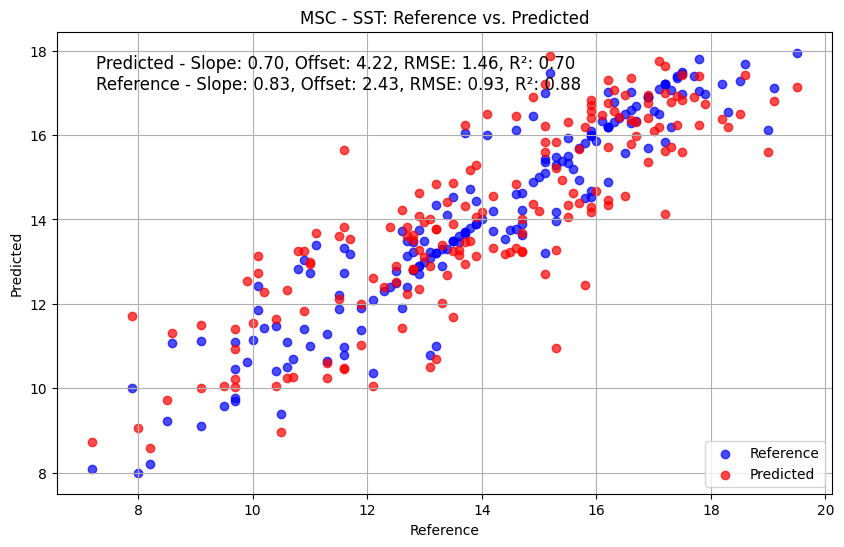

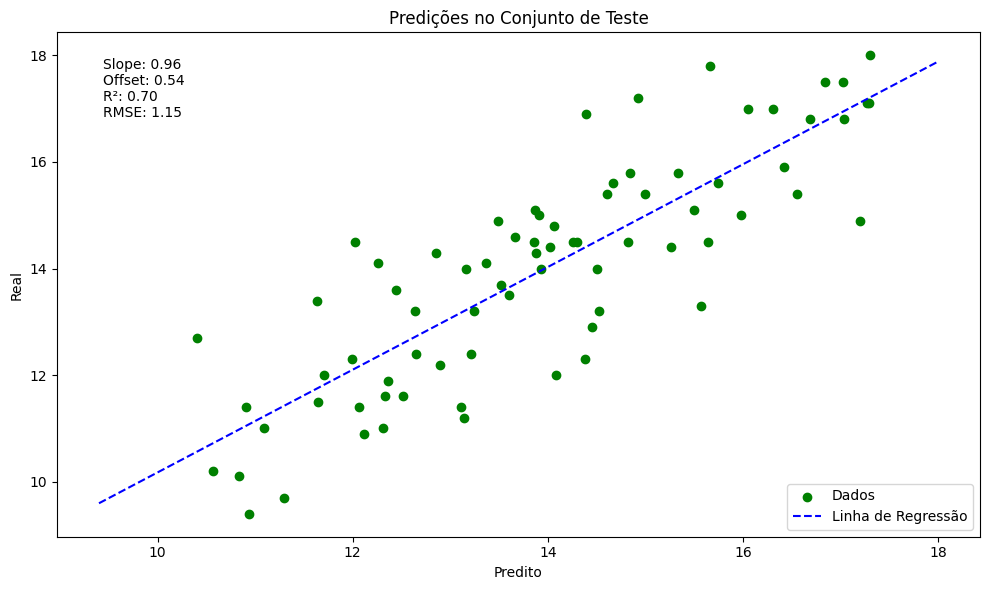

Resultados salvos em: svm_results.xlsx, na aba: MSC_SST


In [29]:
results_msc_sst = SVM(df_msc_cal.iloc[:, 6:], df_msc_cal['SST'].values, df_msc_val.iloc[:, 6:], df_msc_val['SST'].values, 'MSC', 'SST')
save_results('MSC', 'SST', results_msc_sst)

=== Training Metrics ===

c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



Correlation coefficient: 0.8457
Mean absolute error: 0.0729
Root mean squared error: 0.3134
Relative absolute error: 16.1241
Root relative squared error: 53.4482
Slope: 0.9785
Offset: 0.0382
R²: 0.7143
Total Number of Instances: 175.0000


c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\U

=== Cross-Validation Metrics ===
Correlation coefficient: 0.6410
Mean absolute error: 0.2576
Root mean squared error: 0.4643
Relative absolute error: 57.0182
Root relative squared error: 79.1759
Slope: 0.7678
Offset: 0.2661
R²: 0.3731
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.7437
Mean absolute error: 0.2198
Root mean squared error: 0.3081
Relative absolute error: 61.8005
Root relative squared error: 70.4429
Slope: 0.7702
Offset: 0.2558
R²: 0.5038
Total Number of Instances: 75.0000


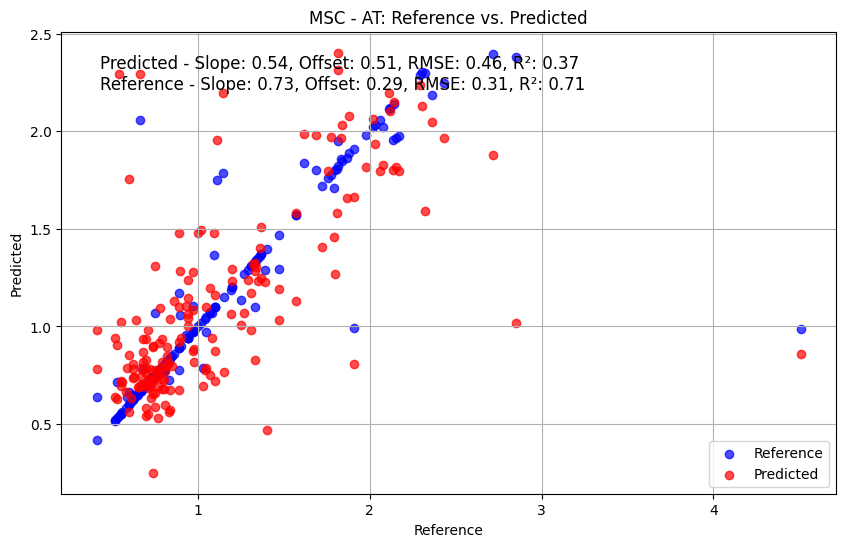

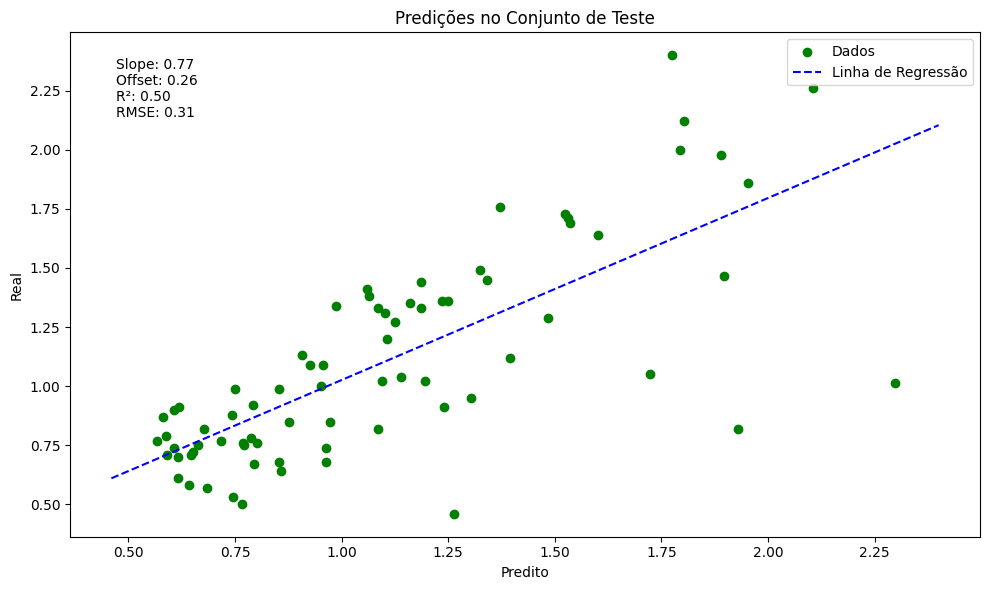

Resultados salvos em: svm_results.xlsx, na aba: MSC_AT


In [30]:
results_msc_at = SVM(df_msc_cal.iloc[:, 6:], df_msc_cal['AT'].values, df_msc_val.iloc[:, 6:], df_msc_val['AT'].values, 'MSC', 'AT')
save_results('MSC', 'AT', results_msc_at)

=== Training Metrics ===

c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



Correlation coefficient: 0.9591
Mean absolute error: 0.0209
Root mean squared error: 0.0874
Relative absolute error: 8.7130
Root relative squared error: 28.3454
Slope: 1.0091
Offset: -0.0263
R²: 0.9197
Total Number of Instances: 175.0000


c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\U

=== Cross-Validation Metrics ===
Correlation coefficient: 0.6548
Mean absolute error: 0.1434
Root mean squared error: 0.2365
Relative absolute error: 59.7964
Root relative squared error: 76.6861
Slope: 0.8344
Offset: 0.5448
R²: 0.4119
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.7000
Mean absolute error: 0.1536
Root mean squared error: 0.2241
Relative absolute error: 65.1726
Root relative squared error: 85.0186
Slope: 0.6331
Offset: 1.2442
R²: 0.2772
Total Number of Instances: 75.0000


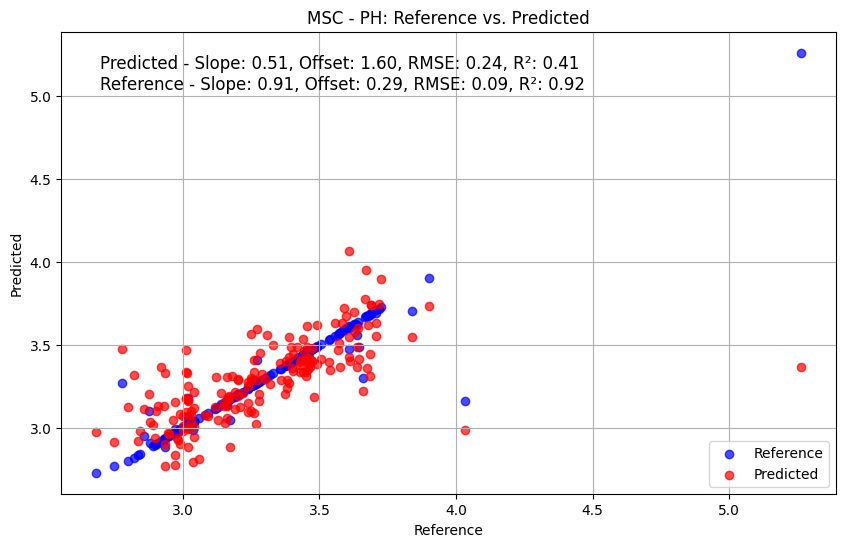

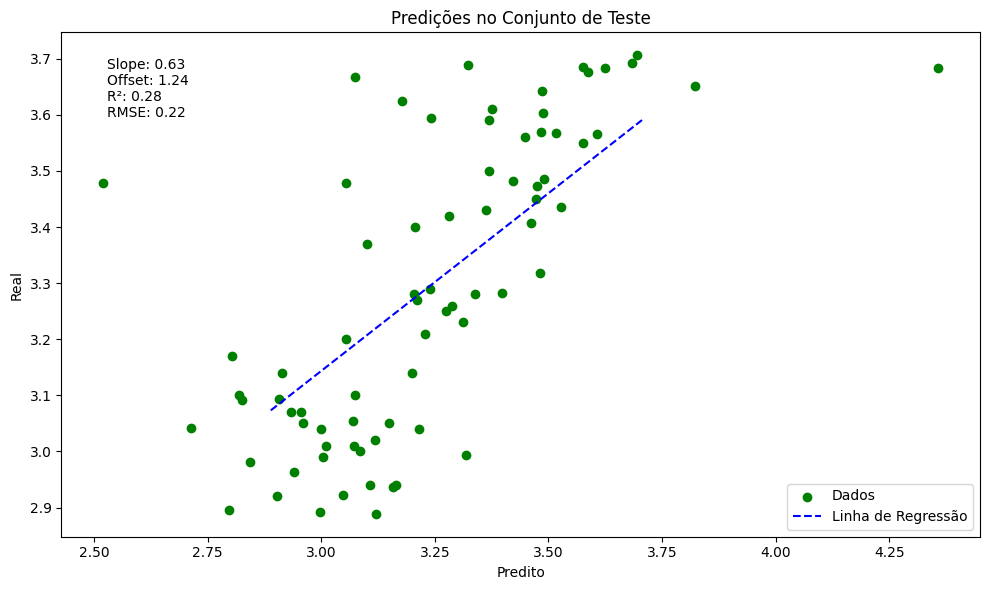

Resultados salvos em: svm_results.xlsx, na aba: MSC_PH


In [31]:
results_msc_ph = SVM(df_msc_cal.iloc[:, 6:], df_msc_cal['PH'].values, df_msc_val.iloc[:, 6:], df_msc_val['PH'].values, 'MSC', 'PH')
save_results('MSC', 'PH', results_msc_ph)

=== Training Metrics ===
Correlation coefficient: 0.7155
Mean absolute error: 66.3341
Root mean squared error: 83.1837
Relative absolute error: 79.6624
Root relative squared error: 80.9416
Slope: 2.3320
Offset: -685.9712
R²: 0.3448
Total Number of Instances: 175.0000
=== Cross-Validation Metrics ===
Correlation coefficient: 0.6705
Mean absolute error: 68.8258
Root mean squared error: 85.2980
Relative absolute error: 82.6547
Root relative squared error: 82.9989
Slope: 2.2461
Offset: -641.2668
R²: 0.3111
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.7051
Mean absolute error: 50.6541
Root mean squared error: 62.0565
Relative absolute error: 79.8059
Root relative squared error: 80.3263
Slope: 1.9060
Offset: -480.5340
R²: 0.3548
Total Number of Instances: 75.0000


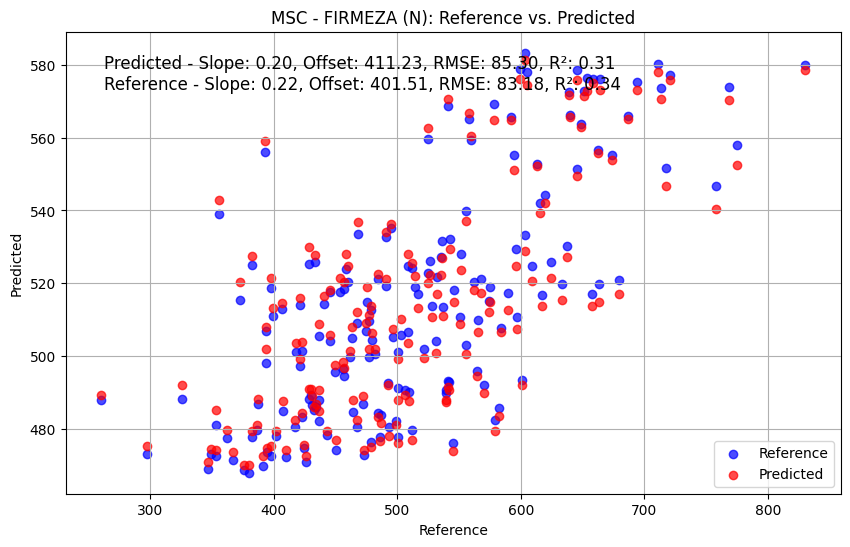

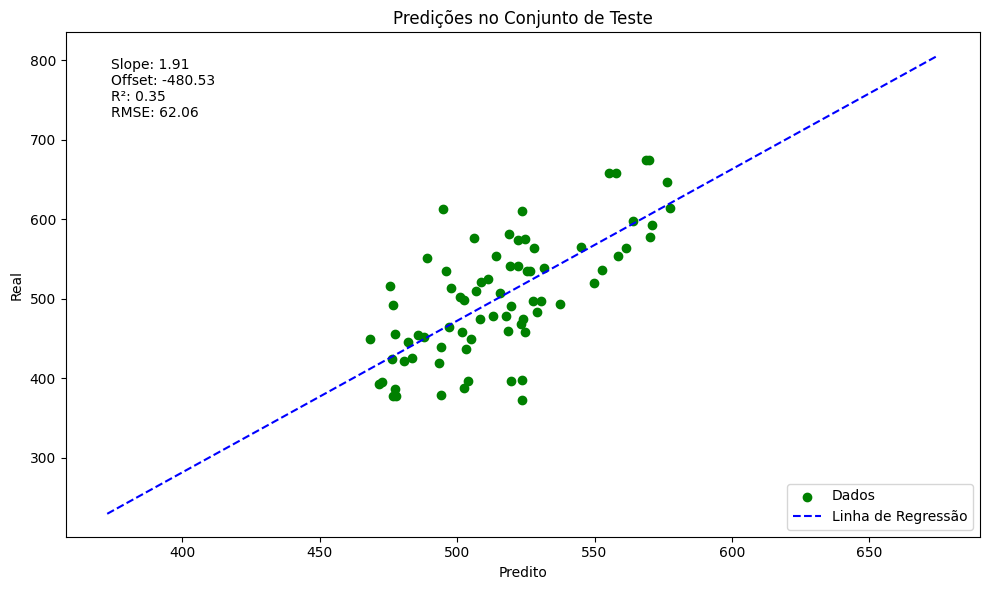

Resultados salvos em: svm_results.xlsx, na aba: MSC_FIRMEZA


In [32]:
results_msc_f = SVM(df_msc_cal.iloc[:, 6:], df_msc_cal['FIRMEZA (N)'].values, df_msc_val.iloc[:, 6:], df_msc_val['FIRMEZA (N)'].values, 'MSC', 'FIRMEZA (N)')
save_results('MSC', 'FIRMEZA', results_msc_f)

=== Training Metrics ===
Correlation coefficient: 0.8817
Mean absolute error: 0.6235
Root mean squared error: 1.5399
Relative absolute error: 25.2357
Root relative squared error: 47.8715
Slope: 1.0993
Offset: -1.4629
R²: 0.7708
Total Number of Instances: 175.0000
=== Cross-Validation Metrics ===
Correlation coefficient: 0.8075
Mean absolute error: 1.1376
Root mean squared error: 1.9053
Relative absolute error: 46.0460
Root relative squared error: 59.2302
Slope: 1.0663
Offset: -0.9467
R²: 0.6492
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.8821
Mean absolute error: 0.8214
Root mean squared error: 1.0280
Relative absolute error: 46.2691
Root relative squared error: 47.4368
Slope: 0.9397
Offset: 0.9153
R²: 0.7750
Total Number of Instances: 75.0000


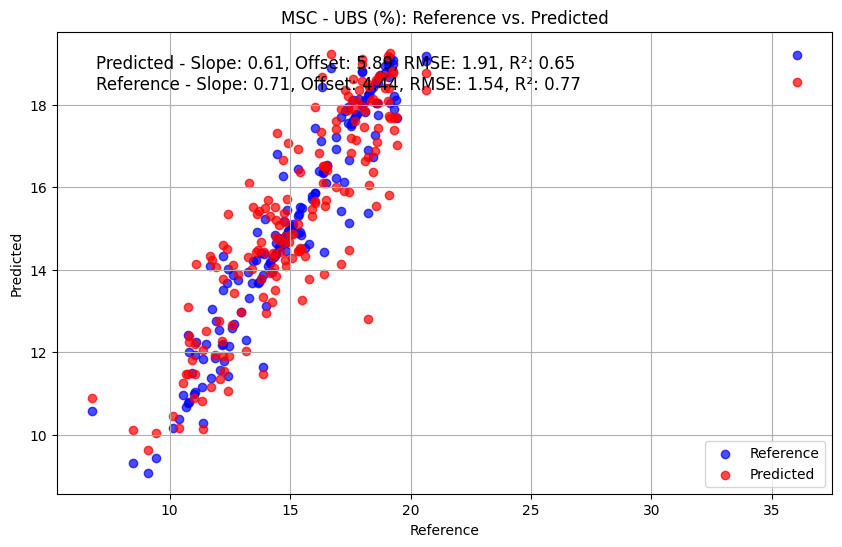

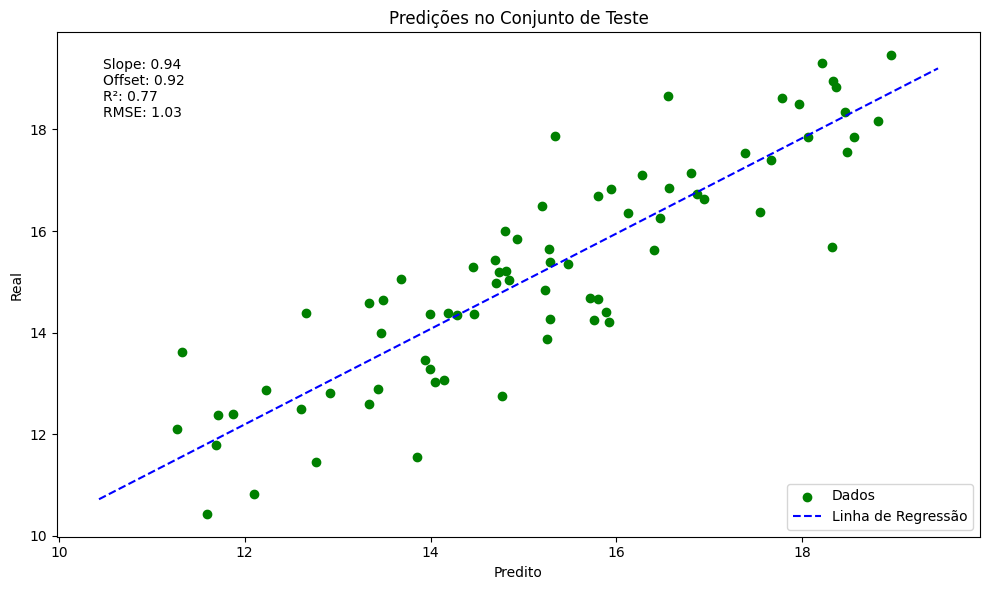

Resultados salvos em: svm_results.xlsx, na aba: MSC_UBS


In [33]:
results_msc_ubs = SVM(df_msc_cal.iloc[:, 6:], df_msc_cal['UBS (%)'].values, df_msc_val.iloc[:, 6:], df_msc_val['UBS (%)'].values, 'MSC', 'UBS (%)')
save_results('MSC', 'UBS', results_msc_ubs)

# SNV - SVMR

=== Training Metrics ===
Correlation coefficient: 0.9403
Mean absolute error: 0.5542
Root mean squared error: 0.9004
Relative absolute error: 25.8872
Root relative squared error: 34.5933
Slope: 1.0654
Offset: -0.9674
R²: 0.8803
Total Number of Instances: 175.0000
=== Cross-Validation Metrics ===
Correlation coefficient: 0.8570
Mean absolute error: 1.0345
Root mean squared error: 1.3437
Relative absolute error: 48.3262
Root relative squared error: 51.6263
Slope: 1.0330
Offset: -0.5015
R²: 0.7335
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.8479
Mean absolute error: 0.9801
Root mean squared error: 1.2308
Relative absolute error: 52.7305
Root relative squared error: 54.7848
Slope: 0.8691
Offset: 1.7501
R²: 0.6999
Total Number of Instances: 75.0000


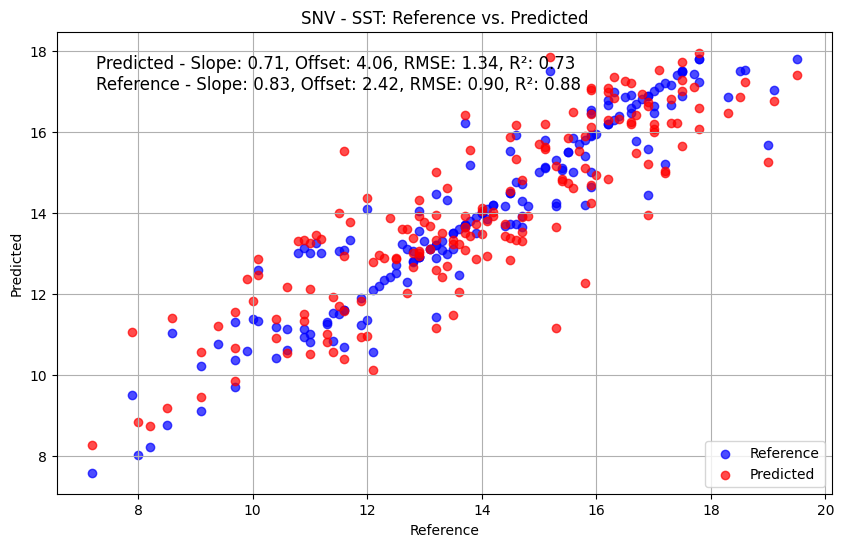

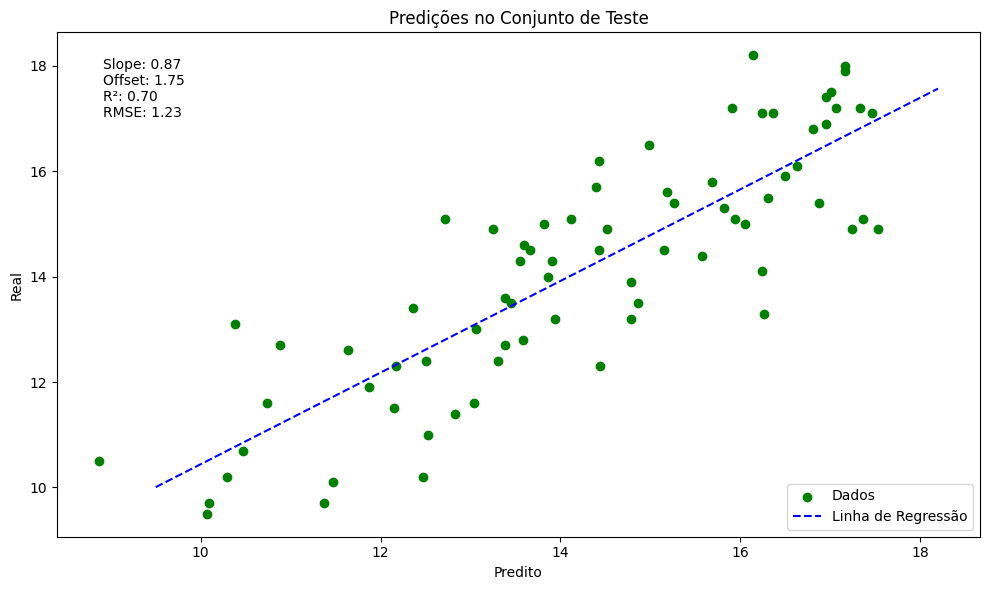

Resultados salvos em: svm_results.xlsx, na aba: SNV_SST


In [34]:
results_snv_sst = SVM(df_snv_cal.iloc[:, 6:], df_snv_cal['SST'].values, df_snv_val.iloc[:, 6:], df_snv_val['SST'].values, 'SNV', 'SST')
save_results('SNV', 'SST', results_snv_sst)

=== Training Metrics ===

c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



Correlation coefficient: 0.8458
Mean absolute error: 0.0723
Root mean squared error: 0.2988
Relative absolute error: 17.1123
Root relative squared error: 53.4303
Slope: 0.9816
Offset: 0.0350
R²: 0.7145
Total Number of Instances: 175.0000


c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\U

=== Cross-Validation Metrics ===
Correlation coefficient: 0.6366
Mean absolute error: 0.2464
Root mean squared error: 0.4450
Relative absolute error: 58.3275
Root relative squared error: 79.5760
Slope: 0.7648
Offset: 0.2698
R²: 0.3668
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.8442
Mean absolute error: 0.1776
Root mean squared error: 0.2784
Relative absolute error: 42.2499
Root relative squared error: 54.2163
Slope: 0.9372
Offset: 0.0408
R²: 0.7061
Total Number of Instances: 75.0000


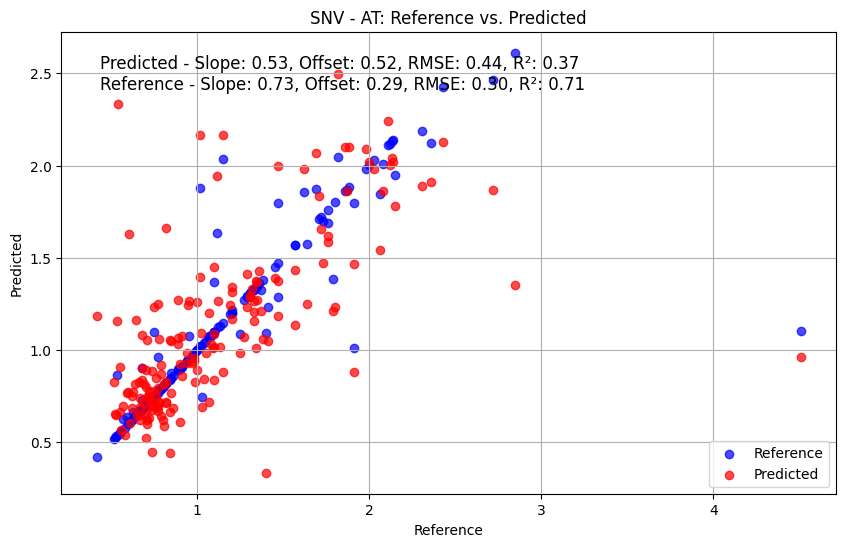

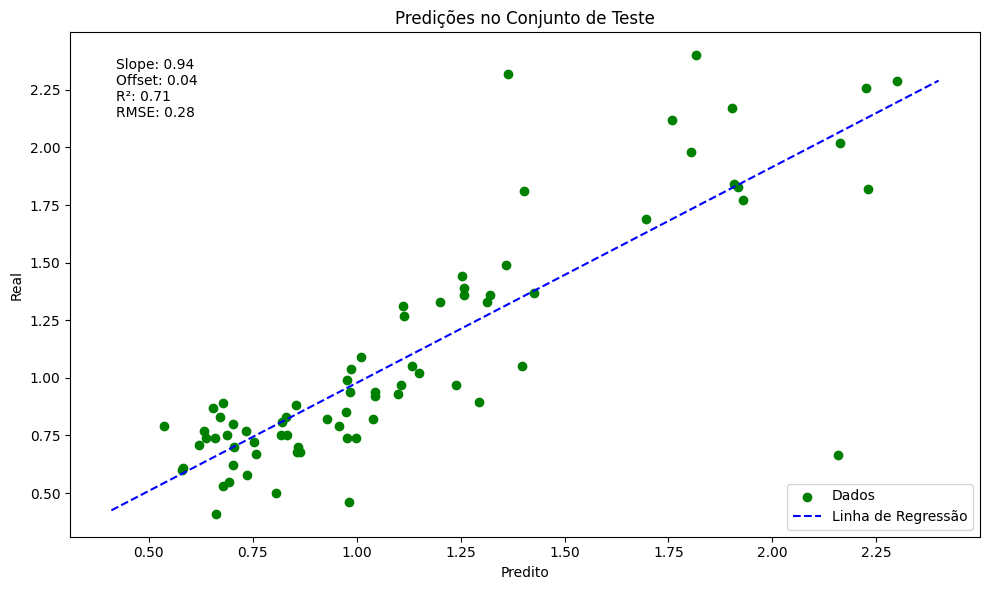

Resultados salvos em: svm_results.xlsx, na aba: SNV_AT


In [35]:
results_snv_at = SVM(df_snv_cal.iloc[:, 6:], df_snv_cal['AT'].values, df_snv_val.iloc[:, 6:], df_snv_val['AT'].values, 'SNV', 'AT')
save_results('SNV', 'AT', results_snv_at)

c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


=== Training Metrics ===
Correlation coefficient: 0.9541
Mean absolute error: 0.0256
Root mean squared error: 0.0943
Relative absolute error: 10.3024
Root relative squared error: 30.1246
Slope: 1.0312
Offset: -0.0975
R²: 0.9093
Total Number of Instances: 175.0000


c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\Luyza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\U

=== Cross-Validation Metrics ===
Correlation coefficient: 0.6303
Mean absolute error: 0.1604
Root mean squared error: 0.2508
Relative absolute error: 64.4991
Root relative squared error: 80.1061
Slope: 0.7618
Offset: 0.7895
R²: 0.3583
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.8230
Mean absolute error: 0.1094
Root mean squared error: 0.1454
Relative absolute error: 51.6790
Root relative squared error: 58.8908
Slope: 0.8414
Offset: 0.5157
R²: 0.6532
Total Number of Instances: 75.0000


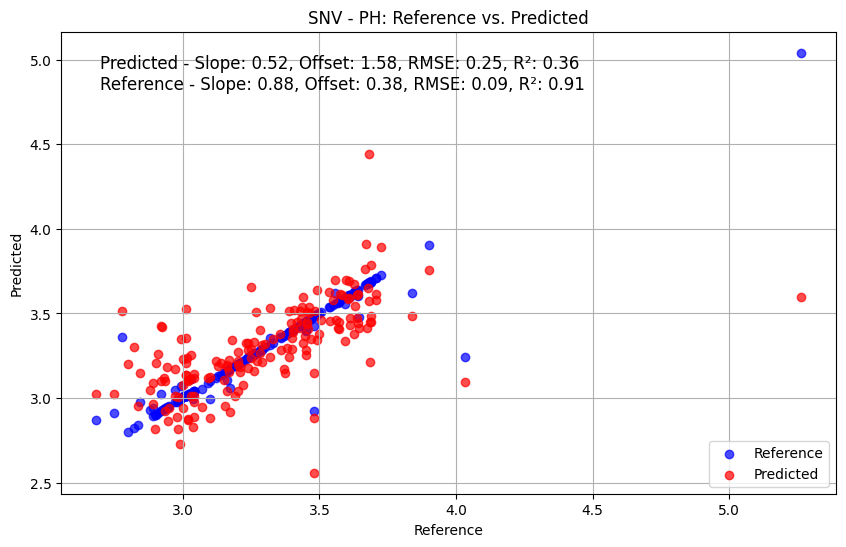

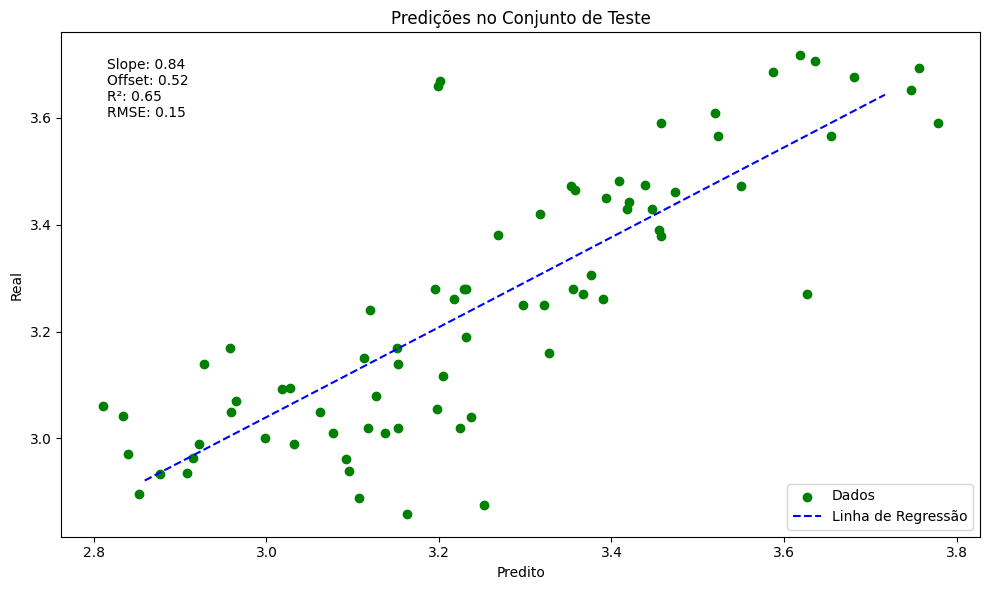

Resultados salvos em: svm_results.xlsx, na aba: SNV_PH


In [36]:
results_snv_ph = SVM(df_snv_cal.iloc[:, 6:], df_snv_cal['PH'].values, df_snv_val.iloc[:, 6:], df_snv_val['PH'].values, 'SNV', 'PH')
save_results('SNV', 'PH', results_snv_ph)

=== Training Metrics ===
Correlation coefficient: 0.6841
Mean absolute error: 65.8291
Root mean squared error: 84.1733
Relative absolute error: 81.3942
Root relative squared error: 83.2658
Slope: 2.4207
Offset: -733.4349
R²: 0.3067
Total Number of Instances: 175.0000
=== Cross-Validation Metrics ===
Correlation coefficient: 0.6420
Mean absolute error: 67.9398
Root mean squared error: 85.9197
Relative absolute error: 84.0039
Root relative squared error: 84.9934
Slope: 2.3318
Offset: -687.0147
R²: 0.2776
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.7923
Mean absolute error: 53.2150
Root mean squared error: 61.1657
Relative absolute error: 79.3198
Root relative squared error: 74.7184
Slope: 2.0136
Offset: -533.4079
R²: 0.4417
Total Number of Instances: 75.0000


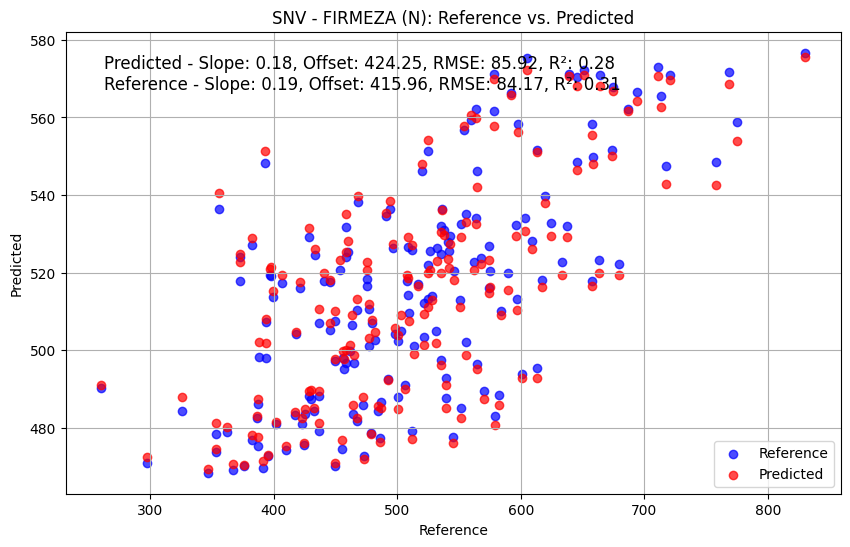

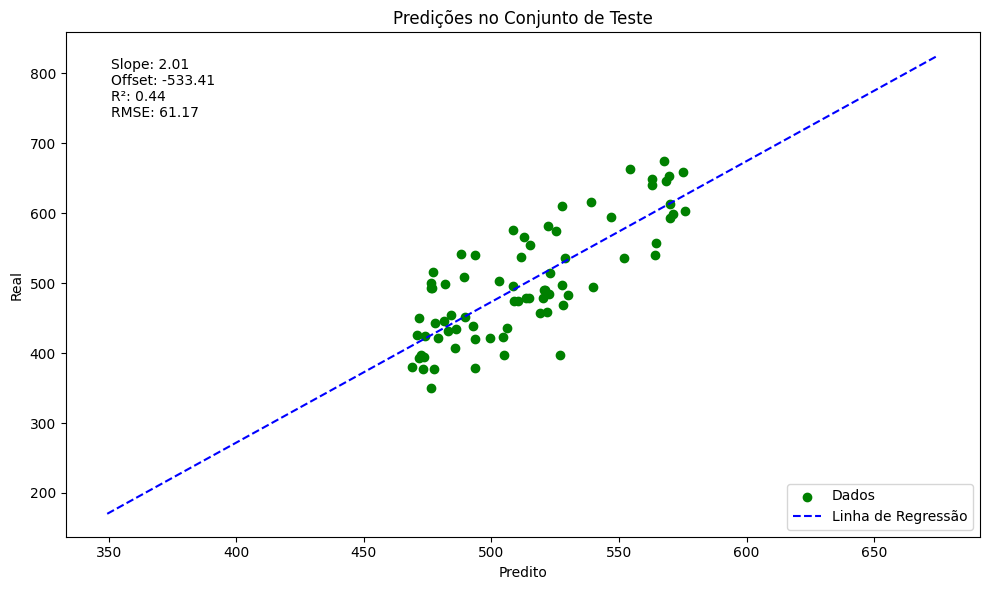

Resultados salvos em: svm_results.xlsx, na aba: SNV_FIRMEZA (N)


In [37]:
results_snv_firmeza = SVM(df_snv_cal.iloc[:, 6:], df_snv_cal['FIRMEZA (N)'].values, df_snv_val.iloc[:, 6:], df_snv_val['FIRMEZA (N)'].values, 'SNV', 'FIRMEZA (N)')
save_results('SNV', 'FIRMEZA (N)', results_snv_firmeza)

=== Training Metrics ===
Correlation coefficient: 0.8820
Mean absolute error: 0.5867
Root mean squared error: 1.5205
Relative absolute error: 24.6049
Root relative squared error: 48.3228
Slope: 1.1328
Offset: -1.9346
R²: 0.7665
Total Number of Instances: 175.0000
=== Cross-Validation Metrics ===
Correlation coefficient: 0.8182
Mean absolute error: 1.0472
Root mean squared error: 1.8299
Relative absolute error: 43.9164
Root relative squared error: 58.1557
Slope: 1.1113
Offset: -1.5917
R²: 0.6618
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.8751
Mean absolute error: 0.9229
Root mean squared error: 1.1880
Relative absolute error: 46.7382
Root relative squared error: 49.5484
Slope: 0.8993
Offset: 1.4558
R²: 0.7545
Total Number of Instances: 75.0000


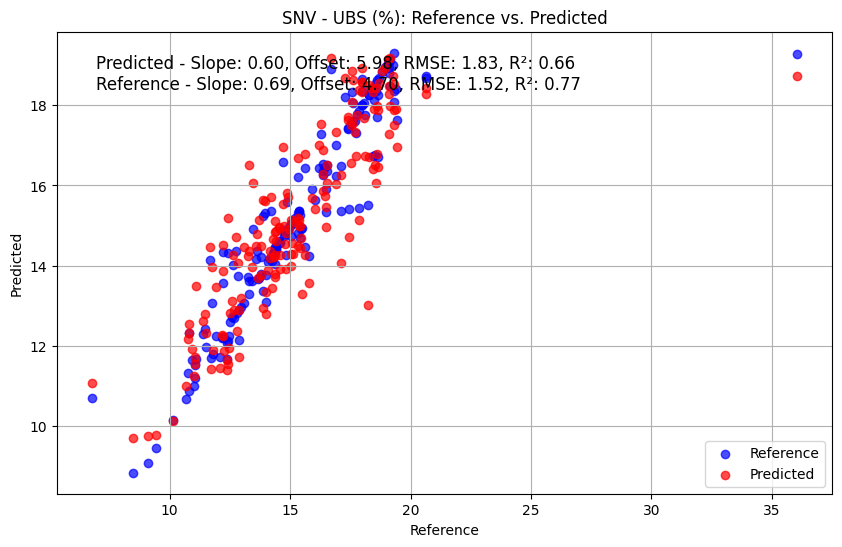

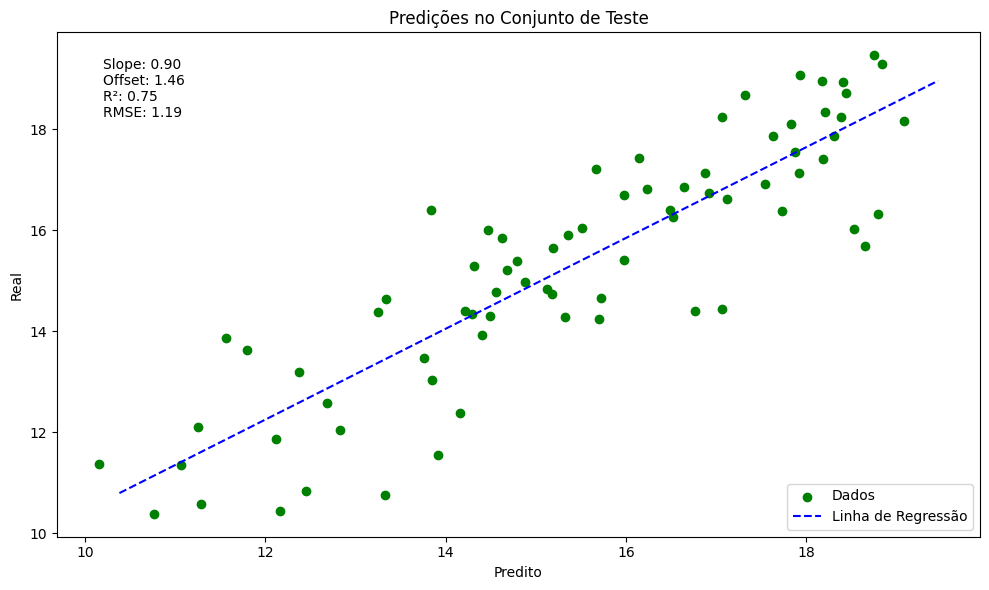

Resultados salvos em: svm_results.xlsx, na aba: SNV_UBS (%)


In [38]:
results_snv_ubs = SVM(df_snv_cal.iloc[:, 6:], df_snv_cal['UBS (%)'].values, df_snv_val.iloc[:, 6:], df_snv_val['UBS (%)'].values, 'SNV', 'UBS (%)')
save_results('SNV', 'UBS (%)', results_snv_ubs)

# SG - SVMR

=== Training Metrics ===
Correlation coefficient: 0.9838
Mean absolute error: 0.2148
Root mean squared error: 0.4840
Relative absolute error: 9.7152
Root relative squared error: 18.2140
Slope: 1.0317
Offset: -0.4632
R²: 0.9668
Total Number of Instances: 175.0000
=== Cross-Validation Metrics ===
Correlation coefficient: 0.8546
Mean absolute error: 1.0631
Root mean squared error: 1.3807
Relative absolute error: 48.0750
Root relative squared error: 51.9607
Slope: 1.0211
Offset: -0.3164
R²: 0.7300
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.8429
Mean absolute error: 0.9032
Root mean squared error: 1.1558
Relative absolute error: 52.6102
Root relative squared error: 54.9923
Slope: 0.8818
Offset: 1.6708
R²: 0.6976
Total Number of Instances: 75.0000


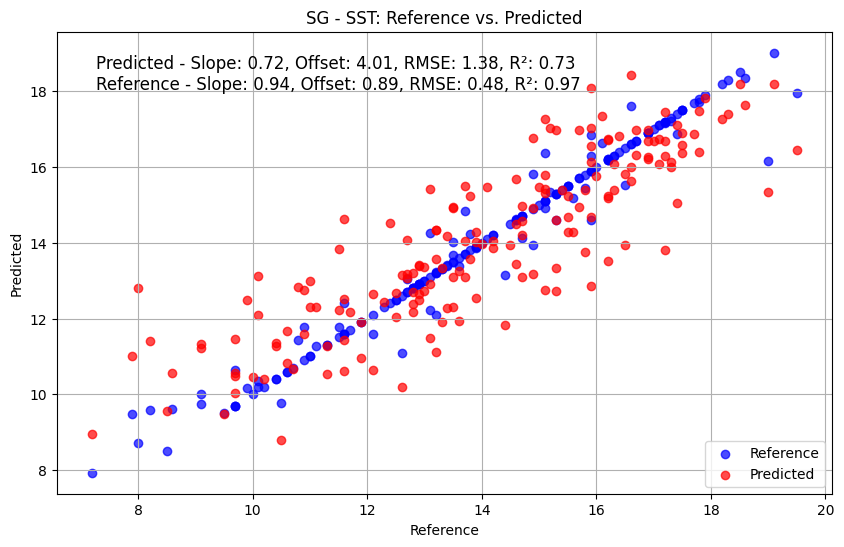

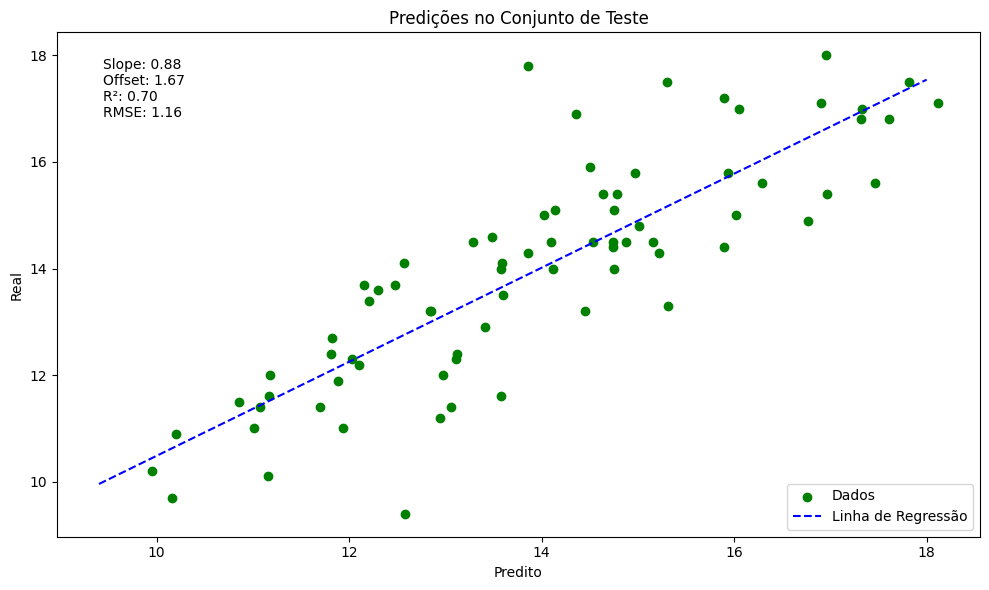

Resultados salvos em: svm_results.xlsx, na aba: SG_SST


In [39]:
results_sg_sst = SVM(df_sg_cal.iloc[:, 6:], df_sg_cal['SST'].values, df_sg_val.iloc[:, 6:], df_sg_val['SST'].values, 'SG', 'SST')
save_results('SG', 'SST', results_sg_sst)

=== Training Metrics ===
Correlation coefficient: 0.9305
Mean absolute error: 0.0198
Root mean squared error: 0.2163
Relative absolute error: 4.3735
Root relative squared error: 36.8679
Slope: 1.0361
Offset: -0.0253
R²: 0.8641
Total Number of Instances: 175.0000
=== Cross-Validation Metrics ===
Correlation coefficient: 0.6876
Mean absolute error: 0.2517
Root mean squared error: 0.4274
Relative absolute error: 55.6239
Root relative squared error: 72.8594
Slope: 0.9251
Offset: 0.0968
R²: 0.4692
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.8343
Mean absolute error: 0.1787
Root mean squared error: 0.2423
Relative absolute error: 50.5167
Root relative squared error: 55.4540
Slope: 0.9339
Offset: 0.0725
R²: 0.6925
Total Number of Instances: 75.0000


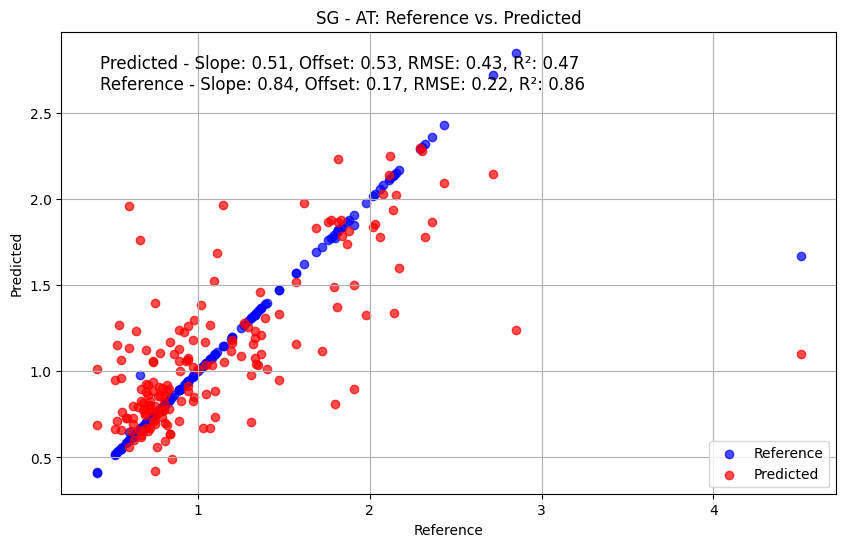

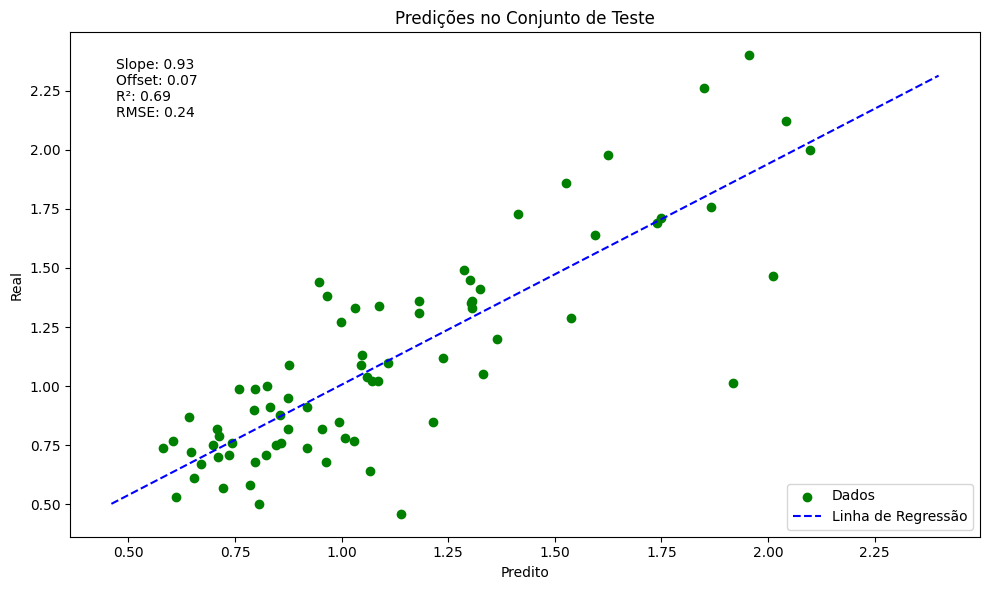

Resultados salvos em: svm_results.xlsx, na aba: SG_AT


In [40]:
results_sg_at = SVM(df_sg_cal.iloc[:, 6:], df_sg_cal['AT'].values, df_sg_val.iloc[:, 6:], df_sg_val['AT'].values, 'SG', 'AT')
save_results('SG', 'AT', results_sg_at)

=== Training Metrics ===
Correlation coefficient: 0.9973
Mean absolute error: 0.0031
Root mean squared error: 0.0231
Relative absolute error: 1.2836
Root relative squared error: 7.4768
Slope: 1.0112
Offset: -0.0347
R²: 0.9944
Total Number of Instances: 175.0000
=== Cross-Validation Metrics ===
Correlation coefficient: 0.6782
Mean absolute error: 0.1332
Root mean squared error: 0.2271
Relative absolute error: 55.4339
Root relative squared error: 73.4894
Slope: 1.0061
Offset: -0.0194
R²: 0.4599
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.8404
Mean absolute error: 0.1039
Root mean squared error: 0.1423
Relative absolute error: 44.3304
Root relative squared error: 54.3691
Slope: 0.9636
Offset: 0.1276
R²: 0.7044
Total Number of Instances: 75.0000


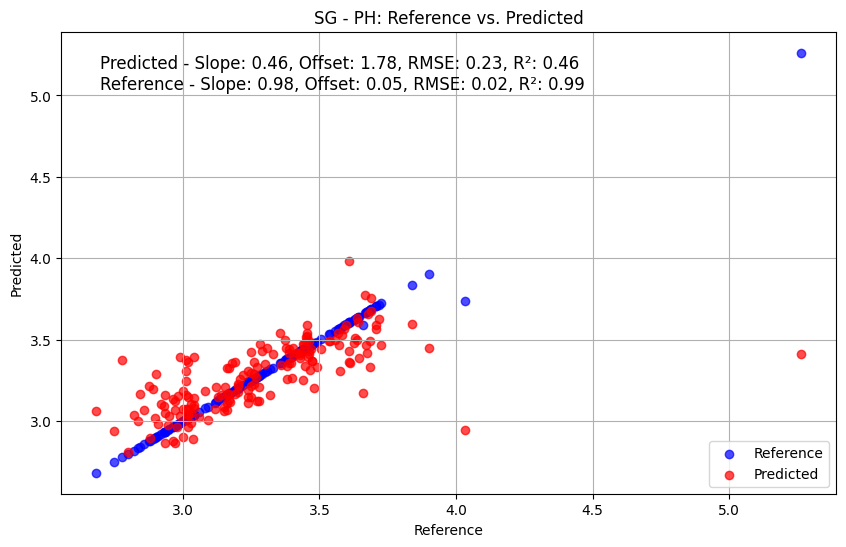

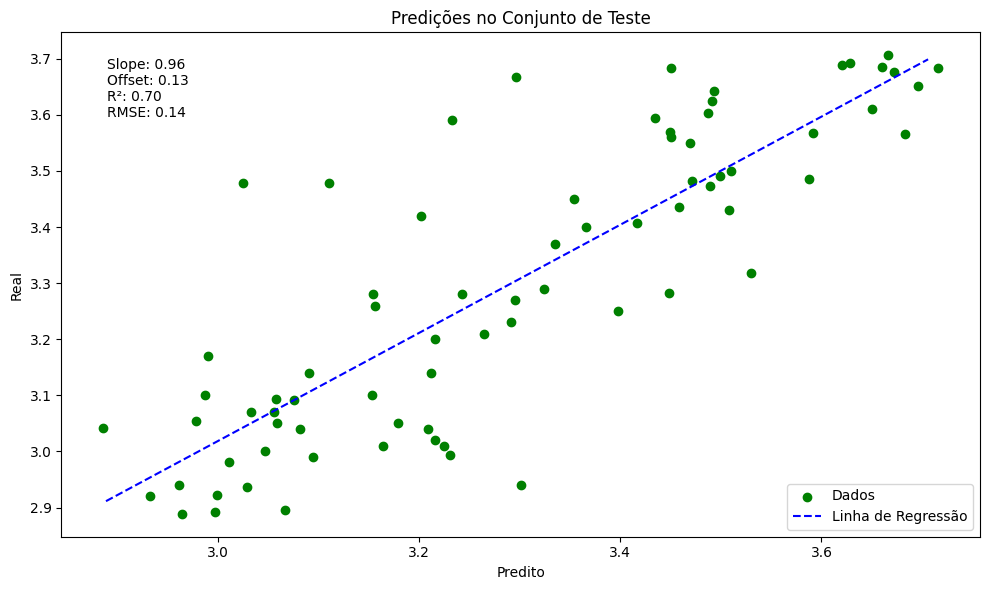

Resultados salvos em: svm_results.xlsx, na aba: SG_PH


In [41]:
results_sg_ph = SVM(df_sg_cal.iloc[:, 6:], df_sg_cal['PH'].values, df_sg_val.iloc[:, 6:], df_sg_val['PH'].values, 'SG', 'PH')
save_results('SG', 'PH', results_sg_ph)

=== Training Metrics ===
Correlation coefficient: 0.7126
Mean absolute error: 71.8130
Root mean squared error: 90.7174
Relative absolute error: 86.2391
Root relative squared error: 88.2708
Slope: 3.9463
Offset: -1486.0100
R²: 0.2208
Total Number of Instances: 175.0000
=== Cross-Validation Metrics ===
Correlation coefficient: 0.6257
Mean absolute error: 74.9347
Root mean squared error: 93.2763
Relative absolute error: 89.9880
Root relative squared error: 90.7607
Slope: 3.7680
Offset: -1395.4812
R²: 0.1762
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.6869
Mean absolute error: 54.2926
Root mean squared error: 66.7259
Relative absolute error: 85.5478
Root relative squared error: 86.3750
Slope: 3.0611
Offset: -1050.0806
R²: 0.2539
Total Number of Instances: 75.0000


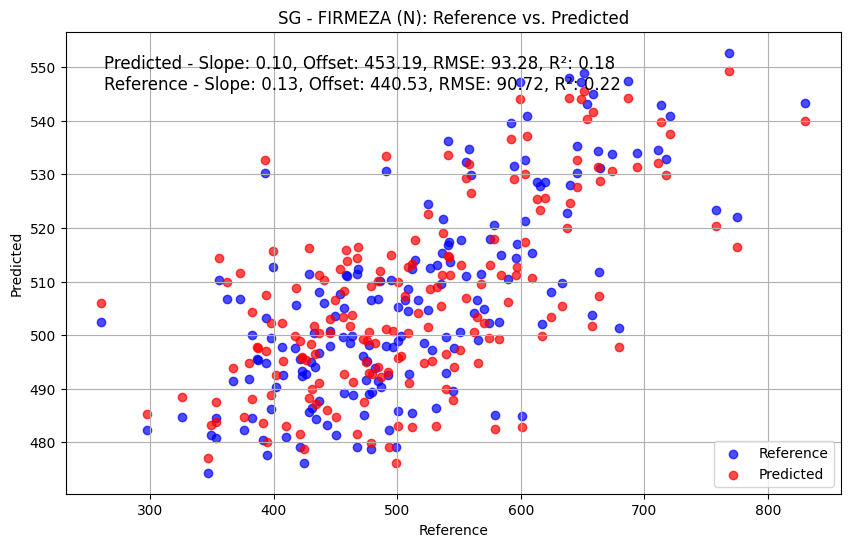

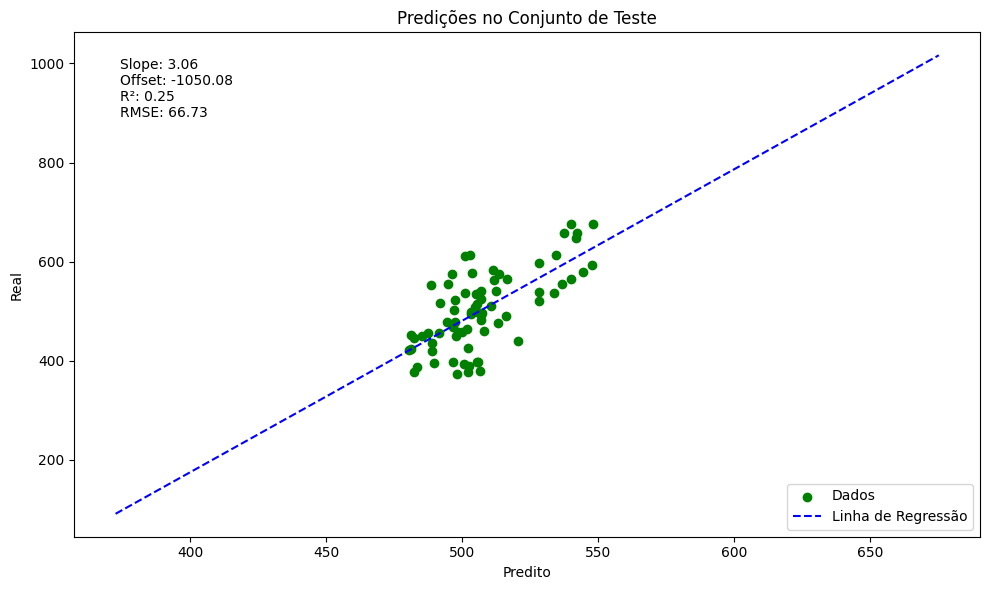

Resultados salvos em: svm_results.xlsx, na aba: SG_FIRMEZA (N)


In [42]:
results_sg_firmeza = SVM(df_sg_cal.iloc[:, 6:], df_sg_cal['FIRMEZA (N)'].values, df_sg_val.iloc[:, 6:], df_sg_val['FIRMEZA (N)'].values, 'SG', 'FIRMEZA (N)')
save_results('SG', 'FIRMEZA (N)', results_sg_firmeza)

=== Training Metrics ===
Correlation coefficient: 0.9201
Mean absolute error: 0.2737
Root mean squared error: 1.2876
Relative absolute error: 11.0834
Root relative squared error: 40.0308
Slope: 1.0976
Offset: -1.4521
R²: 0.8398
Total Number of Instances: 175.0000
=== Cross-Validation Metrics ===
Correlation coefficient: 0.8149
Mean absolute error: 1.1023
Root mean squared error: 1.8822
Relative absolute error: 44.6403
Root relative squared error: 58.5199
Slope: 1.1086
Offset: -1.6140
R²: 0.6575
Total Number of Instances: 175.0000
=== Validation Metrics ===
Correlation coefficient: 0.8913
Mean absolute error: 0.7763
Root mean squared error: 0.9979
Relative absolute error: 43.7516
Root relative squared error: 46.0479
Slope: 0.9237
Offset: 1.0944
R²: 0.7880
Total Number of Instances: 75.0000


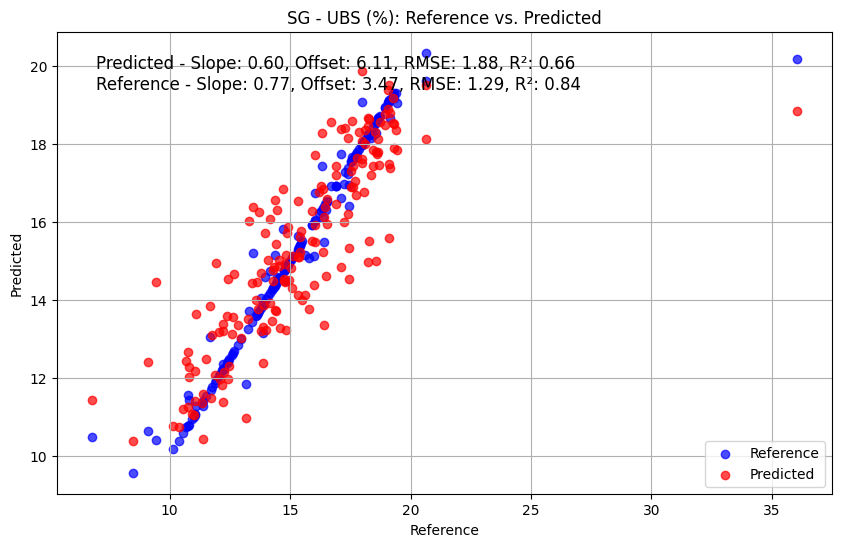

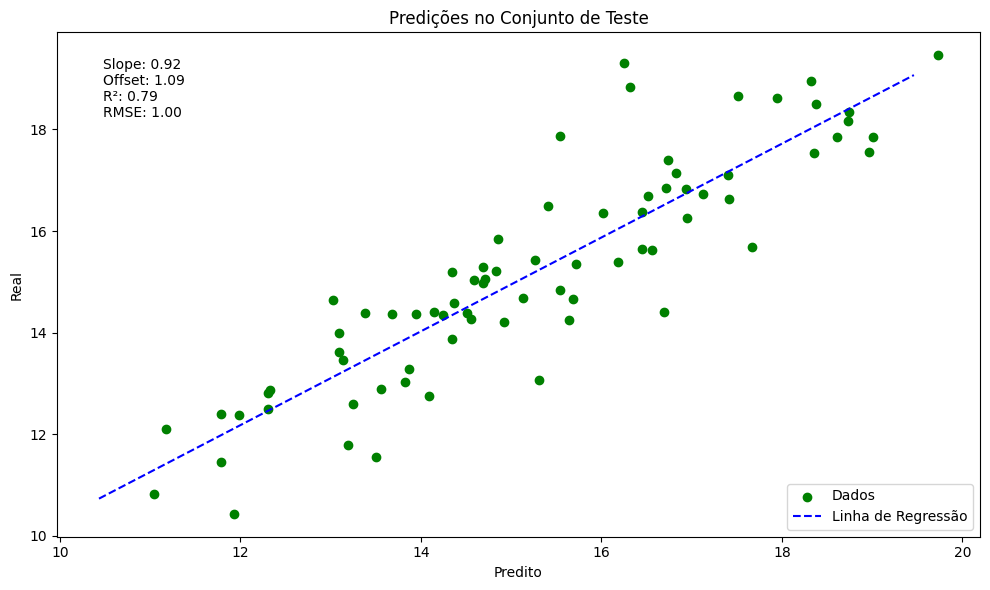

Resultados salvos em: svm_results.xlsx, na aba: SG_UBS (%)


In [43]:
results_sg_ubs = SVM(df_sg_cal.iloc[:, 6:], df_sg_cal['UBS (%)'].values, df_sg_val.iloc[:, 6:], df_sg_val['UBS (%)'].values, 'SG', 'UBS (%)')
save_results('SG', 'UBS (%)', results_sg_ubs)